In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
import tensorflow as tf
import random

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
merged_d = pd.read_csv(r'/content/drive/MyDrive/Dissertation_10862121/merged_d.csv')

In [ ]:
merged_d['GMT'] = pd.to_datetime(merged_d['GMT'])
merged_d['Date'] = pd.to_datetime(merged_d['Date'])
merged_d.set_index('GMT', inplace=True)

Feature Selection

In [ ]:
merged_d = merged_d.drop(columns=["Hourly Mean Windspeed (kn)"])

In [ ]:
#merged_d['temp_humidity_interaction'] = merged_d['Hourly Temperature (C)'] * merged_d['Hourly Relative Humidity (%)']

Feature Engineering

Lags

Consumption

In [ ]:
#Lag for the hour before
merged_d['lag_1_hour_energy'] = merged_d['Total Household Consumption (D)'].shift(1)

#Lags for the same hour for the past 7 days
for i in range(1, 8):
    merged_d[f'lag_{i}_day_energy'] = merged_d['Total Household Consumption (D)'].shift(24 * i)

Temperature

In [ ]:
#Lag for the hour before
merged_d['lag_1_hour_temp'] = merged_d['Hourly Temperature (C)'].shift(1)

#Lags for the same hour for the past 7 days
for i in range(1, 8):
    merged_d[f'lag_{i}_day_temp'] = merged_d['Hourly Temperature (C)'].shift(24 * i)

Radiation

In [ ]:
#Lag for the hour before
merged_d['lag_1_hour_rad'] = merged_d['Hourly Global Radiation (KJ/m2)'].shift(1)

#Lags for the same hour for the past 7 days
for i in range(1, 8):
    merged_d[f'lag_{i}_day_rad'] = merged_d['Hourly Global Radiation (KJ/m2)'].shift(24 * i)

Rolling Statistics - Consumption

In [ ]:
window_size = 72
merged_d['rolling_mean_consumption'] = merged_d['Total Household Consumption (D)'].rolling(window=window_size).mean()

Cyclical Features

In [ ]:
merged_d['hour_sin'] = np.sin(2 * np.pi * merged_d['Hour'] / 24)
merged_d['hour_cos'] = np.cos(2 * np.pi * merged_d['Hour'] / 24)

merged_d['month_sin'] = np.sin(2 * np.pi * merged_d['Month'] / 12)
merged_d['month_cos'] = np.cos(2 * np.pi * merged_d['Month'] / 12)

Weather Combination Variables

In [ ]:
merged_d['temp_rad_interaction'] = merged_d['Hourly Temperature (C)'] * merged_d['Hourly Global Radiation (KJ/m2)']

Weighted Observations (More weight to more recent)

In [ ]:
alpha = 0.9
merged_d['ewm_consumption'] = merged_d['Total Household Consumption (D)'].ewm(alpha=alpha).mean()

Difference between consecutive hours

In [ ]:
merged_d['consumption_diff'] = merged_d['Total Household Consumption (D)'].diff()

Dropping Missing Value Rows after Feature Engineering

In [ ]:
merged_d.dropna(inplace=True)

In [ ]:
merged_d['IsHoliday'] = merged_d['IsHoliday'].astype(int)

In [ ]:
non_num_columns = merged_d.select_dtypes(exclude=['int64', 'float64']).columns
print(non_num_columns)

Index(['Date', 'Time'], dtype='object')


In [ ]:
#Dropping columns that aren't numerical (needed for model input)
merged_d= merged_d.drop(columns=['Date', 'Time'])

In [ ]:
non_num_columns = merged_d.select_dtypes(exclude=['int64', 'float64']).columns
print(non_num_columns)

Index([], dtype='object')


Standard Scaler

In [ ]:
#Selecting numerical columns
numerical_cols = merged_d.select_dtypes(include=['float64', 'int64']).columns

#Applying StandardScaler
standard_scaler = StandardScaler()
merged_d_standard = merged_d.copy()
merged_d_standard[numerical_cols] = standard_scaler.fit_transform(merged_d[numerical_cols])

MinMaxScaler

In [ ]:
minmax_scaler = MinMaxScaler()
merged_d_minmax = merged_d.copy()
merged_d_minmax[numerical_cols] = minmax_scaler.fit_transform(merged_d[numerical_cols])

Data Preparation

Train/Test Split

In [ ]:
end_of_october = merged_d.index.get_loc('2013-10-31').stop - 1
end_of_october

7127

In [ ]:
X = merged_d_standard.drop('Total Household Consumption (D)', axis=1).values
y = merged_d_standard['Total Household Consumption (D)'].values

#Data generation function
def generate_dataset(X, y, time_steps=168, out_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - out_steps):
        v = X[i:i + time_steps]
        Xs.append(v)
        ys.append(y[i + time_steps:i + time_steps + out_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24
OUT_STEPS = 1

X_data, y_data = generate_dataset(X, y, TIME_STEPS, OUT_STEPS)

split_index = end_of_october - TIME_STEPS + 1

X_train = X_data[:split_index]
X_test = X_data[split_index:]

y_train = y_data[:split_index]
y_test = y_data[split_index:]

LSTM Build-up

In [ ]:
model = Sequential()
model.add(LSTM(70, activation='relu', input_shape=(TIME_STEPS, X_data.shape[2]), return_sequences=True))
model.add(LSTM(70, activation='relu'))
model.add(Dense(OUT_STEPS))
model.compile(optimizer='adam', loss='mae')

Training the Model

In [ ]:
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2, shuffle=False)

Epoch 1/40
178/178 [==============================] - 11s 39ms/step - loss: 0.5196 - val_loss: 0.4277
Epoch 2/40
178/178 [==============================] - 9s 49ms/step - loss: 0.3167 - val_loss: 0.2744
Epoch 3/40
178/178 [==============================] - 6s 36ms/step - loss: 0.2170 - val_loss: 0.2193
Epoch 4/40
178/178 [==============================] - 8s 46ms/step - loss: 0.1649 - val_loss: 0.1851
Epoch 5/40
178/178 [==============================] - 6s 36ms/step - loss: 0.1613 - val_loss: 0.1657
Epoch 6/40
178/178 [==============================] - 8s 45ms/step - loss: 0.1477 - val_loss: 0.1601
Epoch 7/40
178/178 [==============================] - 7s 38ms/step - loss: 0.1405 - val_loss: 0.1523
Epoch 8/40
178/178 [==============================] - 8s 42ms/step - loss: 0.1436 - val_loss: 0.1480
Epoch 9/40
178/178 [==============================] - 7s 39ms/step - loss: 0.1210 - val_loss: 0.1397
Epoch 10/40
178/178 [==============================] - 7s 41ms/step - loss: 0.1044 - val_l

Test Set Forecast

In [ ]:
forecasts = []

#Looping through the test set and predicting step by step (walk-forward validation approach)
for i in range(len(X_test)):
    last_sequence = X_test[i].reshape(1, TIME_STEPS, X_data.shape[2])
    forecast = model.predict(last_sequence)
    forecasts.append(forecast[0][0])

1/1 [==============================] - 0s 23ms/step


Predicting the last 2 months or last 61 days peak day value and peak day hour

---



In [ ]:
peak_values = []
peak_hours = []

#Iterating every 24 hours for daily peak
for i in range(0, len(forecasts), 24):
    daily_forecasts = forecasts[i:i+24]
    peak_hour = np.argmax(daily_forecasts)
    peak_value = daily_forecasts[peak_hour]

    peak_values.append(peak_value)
    peak_hours.append(peak_hour)

for i, (peak, hour) in enumerate(zip(peak_values, peak_hours)):
    print(f"Day {i+1}: Peak consumption of {peak} at hour {hour}.")

Day 1: Peak consumption of 1.8296985626220703 at hour 18.
Day 2: Peak consumption of 1.7706255912780762 at hour 18.
Day 3: Peak consumption of 2.0060200691223145 at hour 18.
Day 4: Peak consumption of 1.9999092817306519 at hour 18.
Day 5: Peak consumption of 1.8607096672058105 at hour 19.
Day 6: Peak consumption of 1.9183204174041748 at hour 18.
Day 7: Peak consumption of 1.9166038036346436 at hour 19.
Day 8: Peak consumption of 2.1465461254119873 at hour 18.
Day 9: Peak consumption of 2.2535488605499268 at hour 18.
Day 10: Peak consumption of 2.1632320880889893 at hour 19.
Day 11: Peak consumption of 2.106595993041992 at hour 19.
Day 12: Peak consumption of 2.087290048599243 at hour 19.
Day 13: Peak consumption of 2.1981635093688965 at hour 18.
Day 14: Peak consumption of 1.9507668018341064 at hour 19.
Day 15: Peak consumption of 2.0817997455596924 at hour 19.
Day 16: Peak consumption of 2.151195764541626 at hour 18.
Day 17: Peak consumption of 2.5944252014160156 at hour 18.
Day 18: P

Predicting the last 2 months or last 61 days peak day value and peak day hour in Original Scaled values.

In [ ]:
#Creating a separate scaler for the target variable
target_scaler = StandardScaler()
merged_d_standard['Total Household Consumption (D)'] = target_scaler.fit_transform(merged_d[['Total Household Consumption (D)']])

In [ ]:
#Transforming forecasts back to original scale
forecasts_original = target_scaler.inverse_transform(np.array(forecasts).reshape(-1, 1)).flatten()

In [ ]:
#Transforming peak_values back to original scale
peak_values_original = target_scaler.inverse_transform(np.array(peak_values).reshape(-1, 1)).flatten()

In [ ]:
for i, (peak, hour) in enumerate(zip(peak_values_original, peak_hours)):
    print(f"Day {i+1}: Peak consumption of {peak} at hour {hour}.")

Day 1: Peak consumption of 678.4220581054688 at hour 18.
Day 2: Peak consumption of 669.508056640625 at hour 18.
Day 3: Peak consumption of 705.028564453125 at hour 18.
Day 4: Peak consumption of 704.1064453125 at hour 18.
Day 5: Peak consumption of 683.1015625 at hour 19.
Day 6: Peak consumption of 691.7948608398438 at hour 18.
Day 7: Peak consumption of 691.5358276367188 at hour 19.
Day 8: Peak consumption of 726.2335815429688 at hour 18.
Day 9: Peak consumption of 742.3800659179688 at hour 18.
Day 10: Peak consumption of 728.75146484375 at hour 19.
Day 11: Peak consumption of 720.2052001953125 at hour 19.
Day 12: Peak consumption of 717.2919921875 at hour 19.
Day 13: Peak consumption of 734.0225219726562 at hour 18.
Day 14: Peak consumption of 696.69091796875 at hour 19.
Day 15: Peak consumption of 716.4635009765625 at hour 19.
Day 16: Peak consumption of 726.9351806640625 at hour 18.
Day 17: Peak consumption of 793.8174438476562 at hour 18.
Day 18: Peak consumption of 729.517700195

Actual vs Prediction

In [ ]:
actual_peaks = []
actual_peak_hours = []

#Iterating every 24 hours for daily peak
for i in range(0, len(y_test), 24):
    daily_values = y_test[i:i+24]
    peak_hour = np.argmax(daily_values)
    peak_value = daily_values[peak_hour]

    actual_peaks.append(peak_value)
    actual_peak_hours.append(peak_hour)

#Converting actual_peaks back to original scale
actual_peaks_original = target_scaler.inverse_transform(np.array(actual_peaks).reshape(-1, 1)).flatten()

Performance Metrics

In [ ]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Inverse transform y_test
y_test_original = target_scaler.inverse_transform(y_test).flatten()

mape_overall = mean_absolute_percentage_error(y_test_original, forecasts_original)
mae_overall = mean_absolute_error(y_test_original, forecasts_original)

print(f"Overall Mean Absolute Percentage Error (MAPE): {mape_overall:.2f}%")
print(f"Overall Mean Absolute Error (MAE): {mae_overall:.2f}")

#MAE between forecasted peak values and actual peak values
mae_peak_values = mean_absolute_error(actual_peaks_original, peak_values_original)
print(f"Mean Absolute Error for forecasted peak values: {mae_peak_values}")

#MAE between forecasted peak hours and actual peak hours
mae_peak_hours = mean_absolute_error(actual_peak_hours, peak_hours)
print(f"Mean Absolute Error for forecasted peak hours: {mae_peak_hours}")

Overall Mean Absolute Percentage Error (MAPE): 4.58%
Overall Mean Absolute Error (MAE): 21.14
Mean Absolute Error for forecasted peak values: 23.44487906937956
Mean Absolute Error for forecasted peak hours: 0.6721311475409836


Plots

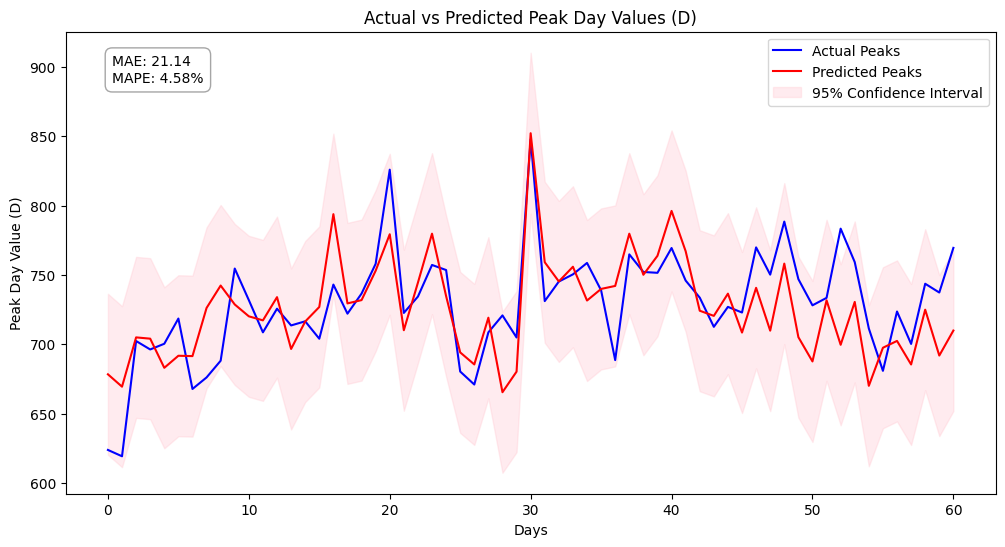

In [ ]:
residuals = actual_peaks_original - peak_values_original
std_residual = np.std(residuals)
lower_bound = peak_values_original - 1.96 * std_residual
upper_bound = peak_values_original + 1.96 * std_residual

plt.figure(figsize=(12, 6))

plt.plot(actual_peaks_original, label="Actual Peaks", color='blue')
plt.plot(peak_values_original, label="Predicted Peaks", color='red')

plt.fill_between(range(len(peak_values_original)), lower_bound, upper_bound, color='pink', alpha=0.3, label="95% Confidence Interval")

plt.title("Actual vs Predicted Peak Day Values (D)")
plt.xlabel("Days")
plt.ylabel("Peak Day Value (D)")
plt.legend()

textstr = f'MAE: {mae_overall:.2f}\nMAPE: {mape_overall:.2f}%'
props = dict(boxstyle='round, pad=0.5', facecolor='white', edgecolor='gray', alpha=0.7)

plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, verticalalignment='top', bbox=props)

plt.show()

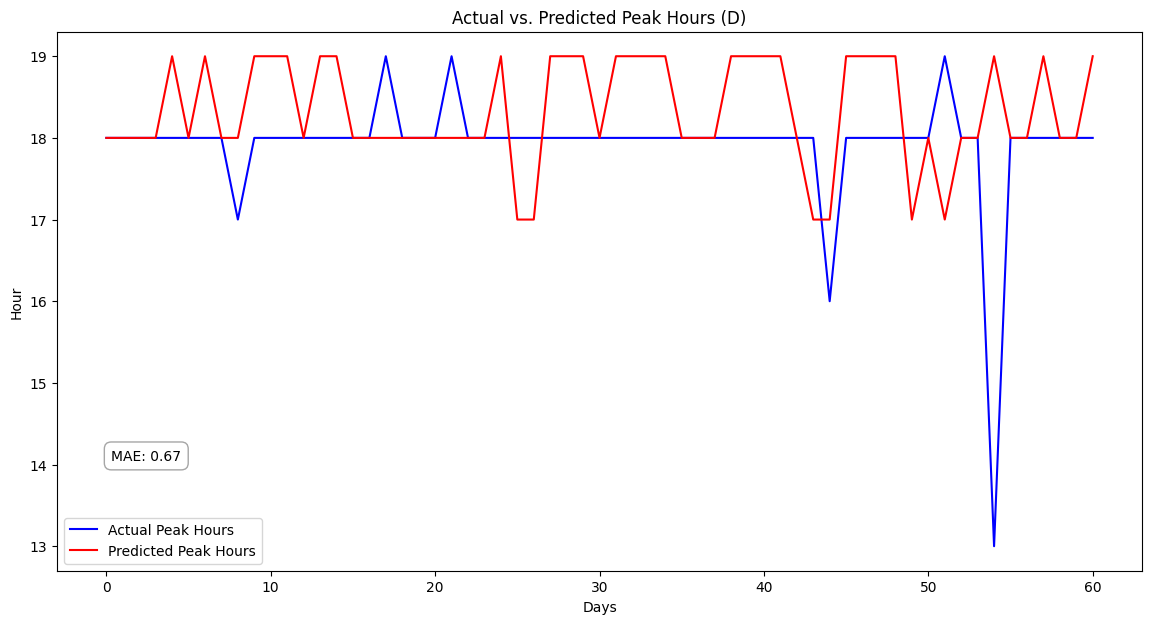

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(actual_peak_hours, label="Actual Peak Hours", color='blue')
plt.plot(peak_hours, label="Predicted Peak Hours", color='red')
plt.title("Actual vs. Predicted Peak Hours (D)")
plt.xlabel("Days")
plt.ylabel("Hour")
plt.legend()

textstr = f'MAE: {mae_peak_hours:.2f}'
props = dict(boxstyle='round, pad=0.5', facecolor='white', edgecolor='gray', alpha=0.7)

plt.text(0.05, 0.2, textstr, transform=plt.gca().transAxes, verticalalignment='bottom', bbox=props)

plt.show()

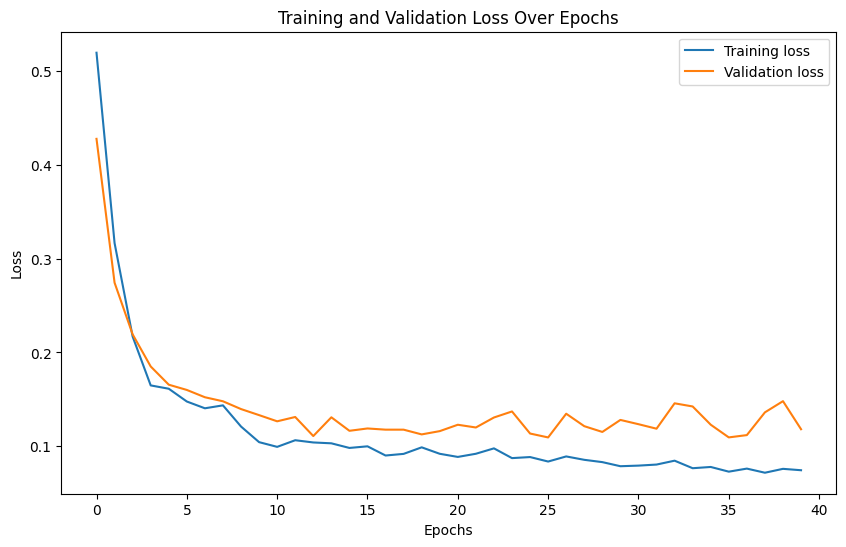

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()